In [2]:
import pandas as pd
import numpy as np
from ogb.graphproppred import PygGraphPropPredDataset,GraphPropPredDataset
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from IPython.display import SVG
from tqdm import tqdm
tqdm.pandas()
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
   
import torch
import numpy as np
from torch.nn.init import normal_ as normal_init
import torch.nn.functional as F
import logging
import os
import time
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score,roc_auc_score,log_loss

In [3]:
DEFAULT_SEED=42
np.random.seed(DEFAULT_SEED)

In [4]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
# torch.cuda.set_device(2)

In [5]:
def numpy_to_torch(d, gpu=True, requires_grad=True):
    """
    numpy array转化为pytorch tensor，有gpu则放到gpu
    :param d:
    :param gpu: whether put tensor to gpu
    :param requires_grad: whether the tensor requires grad
    :return:
    
    Convert numpy array to pytorch tensor, if there is gpu then put into gpu
    :param d:
    :param gpu: whether put tensor to gpu
    :param requires_grad: whether the tensor requires grad
    :return:
    """
    t = torch.from_numpy(d)
    if d.dtype is np.float:
        t.requires_grad = requires_grad
    if gpu:
        t = tensor_to_gpu(t)
    return t


def tensor_to_gpu(t):
    if torch.cuda.device_count() > 0:
        t = t.cuda()
    return t

In [6]:
def mse(self, vector1, vector2):
        vector1, vector2 = self.uniform_size(vector1, vector2, train=False)
        return (vector1 - vector2) ** 2

def dot_product(self, vector1, vector2):
    vector1, vector2 = self.uniform_size(vector1, vector2, train=False)
    result = (vector1 * vector2).sum(dim=-1)
    vector1_pow = vector1.pow(2).sum(dim=-1).pow(self.sim_alpha)
    vector2_pow = vector2.pow(2).sum(dim=-1).pow(self.sim_alpha)
    result = result / torch.clamp(vector1_pow * vector2_pow, min=1e-8)
    return result

def similarity(self, vector1, vector2, sigmoid=True):
    result = F.cosine_similarity(vector1, vector2, dim=-1)
    result = result * self.sim_scale
    if sigmoid:
        return result.sigmoid()
    return result

In [7]:
# prediction = self.similarity(result_vector, self.true).view([-1])

In [8]:
class Datapreprocessing(object):
    def __init__(self,dataset='ogbg-molhiv',path='./dataset/ogbg_molhiv/mapping/mol.csv.gz'):
        self.dataset = dataset
        self.path = path
    
    def read_data(self):
        dataset = GraphPropPredDataset(name = self.dataset)
        split_idx = dataset.get_idx_split()
        self.train_idx, self.valid_idx, self.test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]
        self.df = pd.read_csv(self.path)
    
    def atom_structure_from_smiles(self,smile_input):
        mol = Chem.MolFromSmiles(smile_input)   
        atom_stc_list = []
        for i in mol.GetBonds():
            atom_stc_list.append((i.GetBondType().name,i.GetBeginAtom().GetSymbol(),i.GetEndAtom().GetSymbol()))
        return atom_stc_list
    
    def create_bond_list(self):
        self.df['bond_list'] = self.df['smiles'].progress_apply(lambda x:self.atom_structure_from_smiles(x))
    
    
    def create_atom_bond_labeler(self):
        all_atoms = set()
        all_bonds = set()
        for j in self.df['bond_list'].values:
            atom_lst = []
            bond_lst = set()
            for i in ([([i[1],i[2]],i[0]) for i in j]):
                atom_lst.extend(i[0])
                bond_lst.add(i[1])
            mol_atoms = set(atom_lst)
            all_atoms = all_atoms.union(mol_atoms)
            all_bonds = all_bonds.union(bond_lst)
        bond_dict = dict(zip(all_bonds,[i for i in range(1,len(all_bonds)+1)]))
        atom_dict = dict(zip(all_atoms,[i for i in range(len(all_atoms)+1)]))
        self.bond_dict = bond_dict
        self.atom_dict = atom_dict
        self.num_atoms = len(all_atoms)
        
    def logical_statement_creator(self,bond_list):
        lst = []
        for i in bond_list:
            lst.append(str(self.atom_dict.get(i[1],0))+"-"+str(self.bond_dict.get(i[0],0))+"-"+str(self.atom_dict.get(i[2],0)))
        return "^".join(lst)
    
    def create_logical_expression(self):
        self.df['logical_expression']= self.df['bond_list'].progress_apply(lambda x: self.logical_statement_creator(x))
        self.df['bond_len'] = self.df.bond_list.apply(lambda x: len(x))
       
    
    
    def data_splitter(self):
        self.train_df, self.valid_df, self.test_df = self.df.iloc[self.train_idx] , self.df.iloc[self.valid_idx] , self.df.iloc[self.test_idx] 
        self.train_df = self.train_df[self.train_df['bond_len'] > 1]
        self.valid_df = self.valid_df[self.valid_df['bond_len'] > 1]
        self.test_df = self.test_df[self.test_df['bond_len'] > 1]


In [9]:
dataset = Datapreprocessing()
dataset.read_data()
dataset.create_bond_list()
dataset.create_atom_bond_labeler()
dataset.create_logical_expression()
dataset.data_splitter()

 85%|████████▌ | 34965/41127 [00:18<00:03, 1713.47it/s]RDKit WARNING: [23:46:15] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [23:46:15] WARNING: not removing hydrogen atom without neighbors
100%|██████████| 41127/41127 [00:01<00:00, 20689.11it/s]


In [10]:
class MolDataset(Dataset):
    # load the dataset
    def __init__(self, df,device='cuda'):
        
        # store the inputs and outputs
        
        
        
        df["input"] =  df["logical_expression"].apply(lambda x: np.array([i.split("-") for i in x.split('^')]).astype(int))
        self.X = df.input.values
        self.y = df.HIV_active.values
        
#         self.X = self.X.to(device)
#         self.y = self.y.to(device)
         
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [11]:
class Dataloder(object):
    def __init__(self, dataset):
        self.train_df = dataset.train_df
        self.valid_df = dataset.valid_df
        self.test_df = dataset.test_df
    
    
        
        # calculate split
    #     train, test = dataset.get_splits()
        # prepare data loaders
    def preparedata(self):
        
        self.train = MolDataset(self.train_df)
        self.valid = MolDataset(self.valid_df)
        self.test = MolDataset(self.test_df)
        
#         self.train.X.to(device)  #train_dataset.train_data is a Tensor(input data)
#         train_dataset.train_labels.to(CTX)
        
        
        self.train_dl = DataLoader(self.train, batch_size=1, shuffle=True)
        self.valid_dl = DataLoader(self.valid, batch_size=1, shuffle=False)
        self.test_dl = DataLoader(self.test, batch_size=1, shuffle=False)

In [12]:
dataloder = Dataloder(dataset)
dataloder.preparedata()

In [34]:
class GLN(torch.nn.Module):
    """
    """
    def __init__(self, n_atoms, emb_size=600, dropout=0.0, seed=2022, remove_double_not=False):
        super(GLN, self).__init__()
        self.n_atoms = n_atoms
        self.emb_size = emb_size
        self.dropout = dropout
        self.seed = seed
        # set pytorch and numpy seed
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed(self.seed)
        np.random.seed(self.seed)
        # initialization of user and item embeddings
        self.atom_embeddings = torch.nn.Embedding(self.n_atoms, self.emb_size)
        # this is the true anchor vector that is fixed during the training of the model (for this reason it has the
        # requires_grad parameter af False)
        self.true_vector = torch.nn.Parameter(torch.from_numpy(
            np.random.uniform(0, 0.1, size=self.emb_size).astype(np.float32)),
            requires_grad=False)  # gradient is false to disable the training of the vector
        # first layer of NOT network
        self.not_layer_1 = torch.nn.Linear(self.emb_size, self.emb_size)
        # second layer of NOT network (this network has two layers with the same number of neurons)
        self.not_layer_2 = torch.nn.Linear(self.emb_size, self.emb_size)
        # first layer of OR network: it takes two embeddings, so the input size is 2 * emb_size
#         self.or_layer_1 = torch.nn.Linear(2 * self.emb_size, self.emb_size)
#         # second layer of OR network
#         self.or_layer_2 = torch.nn.Linear(self.emb_size, self.emb_size)
#         # first layer of AND network (this network is not directly used, it is used only for the logical regularizers)
        self.and_layer_1 = torch.nn.Linear(2 * self.emb_size, self.emb_size)
        # second layer of AND network
        self.and_layer_2 = torch.nn.Linear(self.emb_size, self.emb_size)
        # first layer of encoder: it converts a pair of user-item vectors in an event vector (refer to the paper)
        self.single_encoder_layer_1 = torch.nn.Linear(2 * self.emb_size, self.emb_size)
        self.single_encoder_layer_2 = torch.nn.Linear(self.emb_size, self.emb_size)
        
        self.double_encoder_layer_1 = torch.nn.Linear(2 * self.emb_size, self.emb_size)
        self.double_encoder_layer_2 = torch.nn.Linear(self.emb_size, self.emb_size)
        
        self.aromatic_encoder_layer_1 = torch.nn.Linear(2 * self.emb_size, self.emb_size)
        self.aromatic_encoder_layer_2 = torch.nn.Linear(self.emb_size, self.emb_size)
        
        self.triple_encoder_layer_1 = torch.nn.Linear(2 * self.emb_size, self.emb_size)
        self.triple_encoder_layer_2 = torch.nn.Linear(self.emb_size, self.emb_size)
        
        
        # dropout layer
        self.dropout_layer = torch.nn.Dropout(self.dropout)
        # initialize the weights of the network
        self.init_weights()
        self.remove_double_not = remove_double_not
        
    

    def init_weights(self):
        """
        It initializes all the weights of the neural architecture as reported in the paper.
        """
        # not
        normal_init(self.not_layer_1.weight, mean=0.0, std=0.01)
        normal_init(self.not_layer_1.bias, mean=0.0, std=0.01)
        normal_init(self.not_layer_2.weight, mean=0.0, std=0.01)
        normal_init(self.not_layer_2.bias, mean=0.0, std=0.01)
        # or
#         normal_init(self.or_layer_1.weight, mean=0.0, std=0.01)
#         normal_init(self.or_layer_1.bias, mean=0.0, std=0.01)
#         normal_init(self.or_layer_2.weight, mean=0.0, std=0.01)
#         normal_init(self.or_layer_2.bias, mean=0.0, std=0.01)
        # and
        normal_init(self.and_layer_1.weight, mean=0.0, std=0.01)
        normal_init(self.and_layer_1.bias, mean=0.0, std=0.01)
        normal_init(self.and_layer_2.weight, mean=0.0, std=0.01)
        normal_init(self.and_layer_2.bias, mean=0.0, std=0.01)
        
        # Single bond encoder
        normal_init(self.single_encoder_layer_1.weight, mean=0.0, std=0.01)
        normal_init(self.single_encoder_layer_1.bias, mean=0.0, std=0.01)
        normal_init(self.single_encoder_layer_2.weight, mean=0.0, std=0.01)
        normal_init(self.single_encoder_layer_2.bias, mean=0.0, std=0.01)
        
        # Double bond encoder
        normal_init(self.double_encoder_layer_1.weight, mean=0.0, std=0.01)
        normal_init(self.double_encoder_layer_1.bias, mean=0.0, std=0.01)
        normal_init(self.double_encoder_layer_2.weight, mean=0.0, std=0.01)
        normal_init(self.double_encoder_layer_2.bias, mean=0.0, std=0.01)
        
        # encoder
        normal_init(self.triple_encoder_layer_1.weight, mean=0.0, std=0.01)
        normal_init(self.triple_encoder_layer_1.bias, mean=0.0, std=0.01)
        normal_init(self.triple_encoder_layer_2.weight, mean=0.0, std=0.01)
        normal_init(self.triple_encoder_layer_2.bias, mean=0.0, std=0.01)
        
        # Aromatic Bond encoder
        normal_init(self.aromatic_encoder_layer_1.weight, mean=0.0, std=0.01)
        normal_init(self.aromatic_encoder_layer_1.bias, mean=0.0, std=0.01)
        normal_init(self.aromatic_encoder_layer_2.weight, mean=0.0, std=0.01)
        normal_init(self.aromatic_encoder_layer_2.bias, mean=0.0, std=0.01)
        
        
        # embeddings
        normal_init(self.atom_embeddings.weight, mean=0.0, std=0.01)
       
    def logic_not(self, vector):

        # ReLU is the activation function selected in the paper
        vector = F.relu(self.not_layer_1(vector))
        if self.training:
            vector = self.dropout_layer(vector)
        out = self.not_layer_2(vector)
        return out

#     def logic_or(self, vector1, vector2, dim=1):
#         """
#         This represents the OR neural module. It takes in input two event vectors and returns a new event vector that is
#         the logical disjunction of the two input event vectors.
#         :param vector1: the first input event vector.
#         :param vector2: the second input event vector.
#         :param dim: the dimension for the concatenation of the two input event vectors.
#         :return: the event vector that is the logical disjunction of the two input event vectors.
#         """
#         vector = torch.cat((vector1, vector2), dim)
#         vector = F.relu(self.or_layer_1(vector))
#         if self.training:
#             vector = self.dropout_layer(vector)
#         out = self.or_layer_2(vector)
#         return out

    def logic_and(self, vector1, vector2, dim=1):
        vector = torch.cat((vector1, vector2), dim)
        vector = F.relu(self.and_layer_1(vector))
        if self.training:
            vector = self.dropout_layer(vector)
        out = self.and_layer_2(vector)
        return out

    def single_bond_encoder(self, atom_atom_vector):
        struct_vector = F.relu(self.single_encoder_layer_1(atom_atom_vector))
        if self.training:
            struct_vector = self.dropout_layer(struct_vector)
        struct_vector = self.single_encoder_layer_2(struct_vector)
        return struct_vector



    def double_bond_encoder(self, atom_atom_vector):
        struct_vector = F.relu(self.double_encoder_layer_1(atom_atom_vector))
        if self.training:
            struct_vector = self.dropout_layer(struct_vector)
        struct_vector = self.double_encoder_layer_2(struct_vector)
        return struct_vector

    def triple_bond_encoder(self, atom_atom_vector):
        struct_vector = F.relu(self.triple_encoder_layer_1(atom_atom_vector))
        if self.training:
            struct_vector = self.dropout_layer(struct_vector)
        struct_vector = self.triple_encoder_layer_2(struct_vector)
        return struct_vector

    def aromatic_bond_encoder(self, atom_atom_vector):
        struct_vector = F.relu(self.aromatic_encoder_layer_1(atom_atom_vector))
        if self.training:
            struct_vector = self.dropout_layer(struct_vector)
        struct_vector = self.aromatic_encoder_layer_2(struct_vector)
        return struct_vector
    
    def mse(self, vector1, vector2):
        vector1, vector2 = self.uniform_size(vector1, vector2, train=False)
        return (vector1 - vector2) ** 2

    def dot_product(self, vector1, vector2):
        vector1, vector2 = self.uniform_size(vector1, vector2, train=False)
        result = (vector1 * vector2).sum(dim=-1)
        vector1_pow = vector1.pow(2).sum(dim=-1).pow(self.sim_alpha)
        vector2_pow = vector2.pow(2).sum(dim=-1).pow(self.sim_alpha)
        result = result / torch.clamp(vector1_pow * vector2_pow, min=1e-8)
        return result

    def similarity(self, vector1, vector2, sigmoid=True):
        result = F.cosine_similarity(vector1, vector2, dim=-1)
        result = result * 10
        if sigmoid:
            return result.sigmoid()
        return result

    def forward(self, batch_data):
        """
        
        """
        atoms_list = batch_data.to(device)        
        atoms_list = atoms_list[0]
        
        # {'DOUBLE': 1, 'AROMATIC': 2, 'SINGLE': 3, 'TRIPLE': 4}
        
        constraints = []
        struct_list = []
        atom_comb = []
        
        for i in atoms_list:
            atom_left = self.atom_embeddings(i[0]).unsqueeze(0)
            atom_right = self.atom_embeddings(i[2]).unsqueeze(0)
            atomcomb = torch.cat([atom_left, atom_right], dim=1)
            atom_comb.append(atomcomb)

#             print(i,i[1],torch.tensor(3))
            if i[1] == torch.tensor(3):              
                struct_encoder = self.single_bond_encoder(atomcomb) 
            elif i[1] == torch.tensor(1):
                struct_encoder = self.double_bond_encoder(atomcomb)
            elif i[1] == torch.tensor(4):
                struct_encoder = self.triple_bond_encoder(atomcomb)
            else:
                struct_encoder = self.aromatic_bond_encoder(atomcomb)
            struct_list.append(struct_encoder)
        
        while len(struct_list) > 1:
            op1 = struct_list[-1]
            op2 = struct_list[-2]
            struct_list = struct_list[:-2 or None]
#             print(op1)
            
            and_res = self.logic_and(op1,op2)
#             print(len(struct_list))
            struct_list.append(and_res)
            constraints.append(and_res)
#         print(constraints)
        if len(constraints) > 0:
            constraints = torch.cat(constraints, dim=1)
        constraints = constraints.view( constraints.size(1)//self.emb_size, self.emb_size)
        
        if len(atom_comb) > 0:
            atom_comb = torch.cat(atom_comb, dim=1)
        atom_comb = atom_comb.view( atom_comb.size(1)//(self.emb_size*2), self.emb_size*2)

        
        prediction = self.similarity(struct_list[0], self.true_vector).view([-1])
        return prediction, constraints,atom_comb

In [35]:
class GLNTrainer(object):
   
    def __init__(self, net,dataloder, learning_rate=5e-6, l2_weight=1e-4, logic_reg_weight=0.1,atomcomb_reg_weight=0.01,weights = [1.0,10.0]):
        self.network = net
        self.lr = learning_rate
        self.l2_weight = l2_weight
        self.logic_reg_weight = logic_reg_weight
        self.atomcomb_reg_weight = atomcomb_reg_weight
        self.weights = torch.FloatTensor(weights) 
        self.optimizer = optim.Adam(self.network.parameters(), lr=self.lr, weight_decay=self.l2_weight)
        self.dl = dataloder
       
    def logic_reg_loss(self, constraints):
        """
        It computes the regularization part of the loss function.
        :param constraints: see loss_function()
        :return: the regularization loss for the batch intermediate event vectors given in input.
        """
        false_vector = self.network.logic_not(self.network.true_vector)  # we compute the representation
        
        # here, we maximize the similarity between not not true and true
        r_not_not_true = (1 - F.cosine_similarity(
            self.network.logic_not(self.network.logic_not(self.network.true_vector)), self.network.true_vector,dim=0))

#         here, we maximize the similarity between not true and false
        r_not_true = (1 - F.cosine_similarity(self.network.logic_not(self.network.true_vector), false_vector, dim=0))

 
        # here, we maximize the similarity between x AND True and x
        r_and_true = (1 - F.cosine_similarity(
            self.network.logic_and(constraints, self.network.true_vector.expand_as(constraints)), constraints)).mean()

        # here, we maximize the similarity between x AND False and False
        r_and_false = (1 - F.cosine_similarity(
            self.network.logic_and(constraints, false_vector.expand_as(constraints)),
            false_vector.expand_as(constraints))).mean()

        # here, we maximize the similarity between x AND x and x
        r_and_self = (1 - F.cosine_similarity(self.network.logic_and(constraints, constraints), constraints)).mean()

        # here, we maximize the similarity between x AND not x and False
        r_and_not_self = (1 - F.cosine_similarity(
            self.network.logic_and(constraints, self.network.logic_not(constraints)),
            false_vector.expand_as(constraints))).mean()

        # same rule as before, but we flipped operands
        r_and_not_self_inverse = (1 - F.cosine_similarity(
            self.network.logic_and(self.network.logic_not(constraints), constraints),
            false_vector.expand_as(constraints))).mean()

        # True/False rule

        # here, we minimize the similarity between True and False
        true_false = 1 + F.cosine_similarity(self.network.true_vector, false_vector, dim=0)

        r_loss = r_not_not_true + r_not_true + r_and_true + r_and_false + r_and_self + r_and_not_self + r_and_not_self_inverse

        return r_loss

    
    def atomcombination_reg_loss(self, atoms_combs):
        """
        It computes the regularization part of the loss function.
        :param constraints: see loss_function()
        :return: the regularization loss for the batch intermediate event vectors given in input.
        """
        
        # here, we maximize the similarity between not not true and true
        
        reverse_atom_combs = torch.cat((atoms_combs[:, self.network.emb_size:],atoms_combs[:, :self.network.emb_size]), 1)
        single_bond_loss = (1 - F.cosine_similarity(self.network.single_bond_encoder(atoms_combs), self.network.single_bond_encoder(reverse_atom_combs))).mean()

#         here, we maximize the similarity between not true and false
        double_bond_losss = (1 - F.cosine_similarity(self.network.double_bond_encoder(atoms_combs), self.network.double_bond_encoder(reverse_atom_combs))).mean()

 
        # here, we maximize the similarity between x AND True and x
        aromatic_bond_loss = (1 - F.cosine_similarity(self.network.aromatic_bond_encoder(atoms_combs), self.network.aromatic_bond_encoder(reverse_atom_combs))).mean()

        # here, we maximize the similarity between x AND False and False
        tripple_bond_loss = (1 - F.cosine_similarity(self.network.triple_bond_encoder(atoms_combs), self.network.triple_bond_encoder(reverse_atom_combs))).mean()

        
        ac_loss = single_bond_loss + double_bond_losss + aromatic_bond_loss + tripple_bond_loss
        
        return ac_loss

    
    
    
    def BCELoss_class_weighted(self,predicton, target,weights):
        input = torch.clamp(predicton,min=1e-7,max=1-1e-7)
        bce = - weights[1] * target * torch.log(predicton) - (1 - target) * weights[0] * torch.log(1 - predicton)
        return torch.mean(bce)
    
    
        

    def loss_function(self, prediction, label, logic_constraints,atoms_combs):
        """
        This method computes the loss function for a single batch. It takes as inputs the predictions for positive
        and negative logical expressions and a tensor containing the intermediate event vectors obtained while building
        the logical expressions of the batch. The loss is computed as reported in the paper.
        :param positive_preds: predictions for positive logical expressions.
        :param negative_preds: predictions for negative logical expressions.
        :param constraints: tensor containing the intermediate event vectors obtained while building the logical
        expressions of the batch.
        :return the partial loss function for the given batch.
        """
        # here, implement loss function
        
#         print(type(prediction),type(label))
#         weights = torch.FloatTensor([1.0, 10.0]) 
        
        loss = torch.nn.BCELoss(reduction='sum')(prediction.to(torch.float64), label.to(torch.float64))
#         loss = self.BCELoss_class_weighted(prediction.to(torch.float64), label.to(torch.float64),self.weights)
        
        
        logic_reg_loss = self.logic_reg_loss(logic_constraints)
        atomcombination_reg_loss = self.atomcombination_reg_loss(atoms_combs)

        return loss + self.logic_reg_weight * logic_reg_loss + self.atomcomb_reg_weight * atomcombination_reg_loss

    def train(self,
              train_data = dataloder.train_dl,
              valid_data=None,
              valid_metric='auc_roc',
              num_epochs=20,
              at_least=20,
              early_stop=5,
              save_path="../saved_models/best_gln_model.json",
              verbose=1):
        
        best_val = 0.0
        early_stop_counter = 0
        early_stop_flag = False
        if early_stop > 1:  # it means that the parameter is meaningful
            early_stop_flag = True
        try:
            for epoch in range(1, num_epochs + 1):
                print(f'Epoch:{epoch}')
                self.train_epoch(epoch, train_data, verbose)
#                 print("Now Model is Evaluating")
                val_lst = self.evaluate_model()
                train_lst = self.evaluate_model(eval_data='Train')
                print(f"Train AUC_ROC: {train_lst[1]} , Train Loss: {train_lst[2]}, Validation AUC_ROC: {val_lst[1]} , Validation Loss: {val_lst[2]}")
                if valid_data is not None:
                    assert valid_metric is not None, \
                                "In case of validation 'valid_metric' must be provided"
                    valid_res = valid_func(self, valid_data, valid_metric)
                    mu_val = np.mean(valid_res)
                    std_err_val = np.std(valid_res) / np.sqrt(len(valid_res))
                    logger.info('| epoch %d | %s %.3f (%.4f) |',
                                epoch, valid_metric, mu_val, std_err_val)
                    if mu_val > best_val:
                        best_val = mu_val
                        self.save_model(save_path, epoch)  # save model if an improved validation score has been
                        # obtained
                        early_stop_counter = 0  # we have reached a new validation best value, so we put the early stop
                        # counter to zero
                    else:
                        # if we did not have obtained an improved validation metric, we have to increase the early
                        # stopping counter
                        if epoch >= at_least and early_stop_flag:  # we have to train for at least 20 epochs, they said that in the paper
                            early_stop_counter += 1
                            if early_stop_counter == early_stop:
                                logger.info('Traing stopped at epoch %d due to early stopping', epoch)
                                break
        except KeyboardInterrupt:
            logger.warning('Handled KeyboardInterrupt: exiting from training early')


    def train_epoch(self, epoch, train_loader, verbose=1):
        """
        This method performs the training of a single epoch.
        :param epoch: id of the epoch.
        :param train_loader: the DataLoader that loads the training set.
        :param verbose: see train() method.
        """
        self.network.train()  # set the network in train mode
        train_loss = 0
        partial_loss = 0
        epoch_start_time = time.time()
        start_time = time.time()
        log_delay = max(10, len(train_loader) // 10**verbose)

        for batch_idx, batch_data_f in enumerate(train_loader):
            batch_data, label = batch_data_f
            batch_data, label = batch_data.to(device), label.to(device) 
            label.to(device)
            partial_loss += self.train_batch(batch_data,label)
            if (batch_idx+1) % log_delay == 0:
                elapsed = time.time() - start_time
#                 logger.info('| epoch %d | %d/%d batches | ms/batch %.2f | loss %.2f |',
#                             epoch, (batch_idx+1), len(train_loader),
#                             elapsed * 1000 / log_delay,
#                             partial_loss / log_delay)
                train_loss += partial_loss
                partial_loss = 0.0
                start_time = time.time()
        total_loss = (train_loss + partial_loss) / len(train_loader)
        time_diff = time.time() - epoch_start_time
#         logger.info("| epoch %d | loss %.4f | total time: %.2fs |", epoch, total_loss, time_diff)

    def train_batch(self, batch_data,label):

        self.optimizer.zero_grad()
        prediction, constraints,atom_combs = self.network(batch_data)
        loss = self.loss_function(prediction, label, constraints,atom_combs)
        loss.backward()
#         print(loss)
        # this gradient clipping leads to lower results, so I removed it
        torch.nn.utils.clip_grad_value_(self.network.parameters(), 50)  # this has been inserted in the code provided
        self.optimizer.step()
        return loss.item()

    def predict(self, batch_data):
        self.network.eval()  # we have to set the network in evaluation mode
        with torch.no_grad():
            prediction, _ = self.network(batch_data)
        return prediction
    
    def evaluate_model(self,eval_data='Val'):
        self.network.eval()
        
        if eval_data=='Val':
            dl = self.dl.valid_dl
        else:
            dl = self.dl.train_dl
        predictions, actuals,probs = list(), list(),list()
        
        for i, (inputs, targets) in enumerate(dl):
            # evaluate the model on the test set
            with torch.no_grad():
                yhat,_,_ = self.network(inputs)
            # retrieve numpy array
            yhat = yhat.cpu().detach().numpy()
            actual = targets.numpy()
            actual = actual.reshape((len(actual), 1))
            probs.append(yhat)
            yhat = yhat.round()

            # store
            predictions.append(yhat)
            actuals.append(actual)
        predictions, actuals,probs =  np.vstack(predictions), np.vstack(actuals),np.vstack(probs)
        # calculate accuracy
        acc = accuracy_score(actuals, predictions)
        auc = roc_auc_score(actuals,probs)
        loss = log_loss(actuals,probs)
        return [acc,auc,loss]
    
    
    

#     def save_model(self, filepath, cur_epoch):
#         """Save the model into the given file.
#         Parameters
#         ----------
#         filepath : :obj:`str`
#             String representing the path to the file where to save the model.
#         cur_epoch : :obj:`int`
#             The current training epoch.
#         """
#         logger.info("Saving model checkpoint to %s...", filepath)
#         torch.save({'epoch': cur_epoch,
#                  'state_dict': self.network.state_dict(),
#                  'optimizer': self.optimizer.state_dict()
#                 }, filepath)
#         logger.info("Model checkpoint saved!")

#     def load_model(self, filepath):
#         """Load the model from the given file.
#         Parameters
#         ----------
#         filepath : :obj:`str`
#             String representing the path to the file where the model is saved.
#         Returns
#         -------
#         :obj:`dict`
#             A dictionary that summarizes the state of the model when it has been saved.
#             Note: not all the information about the model are stored in the saved 'checkpoint'.
#         """
#         assert os.path.isfile(filepath), "The checkpoint file %s does not exist." %filepath
#         logger.info("Loading model checkpoint from %s...", filepath)
#         checkpoint = torch.load(filepath, map_location=torch.device('cpu'))
#         self.network.load_state_dict(checkpoint['state_dict'])
#         self.optimizer.load_state_dict(checkpoint['optimizer'])
#         logger.info("Model checkpoint loaded!")
#         return checkpoint

#     def test(self, test_loader, test_metrics=['ndcg@5', 'ndcg@10', 'hit@5', 'hit@10'], n_times=10):
#         """
#         This method performs the test of a trained NCR model.
#         :param test_loader: this is the DataSampler that loads the test set interactions.
#         :param test_metrics: this is a list containing the test metrics that have to be computed.
#         :param n_times: this is the number of times that the evaluation has to be computed. Since the test loader
#         generates 100 random negative items for each interaction in the test set, different random generations
#         could lead to different test performances. The evaluation will be computed n_times times and then each metric
#         will be averaged among these n_times evaluations.
#         This method will log the value of each one of the metrics (plus std error) once this procedure has finished.
#         """
#         metric_dict = {}
#         for i in range(n_times):  # compute test metrics n_times times and take the mean since negative samples are
#             # randomly generated
#             evaluation_dict = logic_evaluate(self, test_loader, test_metrics)
#             for metric in evaluation_dict:
#                 if metric not in metric_dict:
#                     metric_dict[metric] = {}
#                 metric_mean = np.mean(evaluation_dict[metric])
#                 metric_std_err_val = np.std(evaluation_dict[metric]) / np.sqrt(len(evaluation_dict[metric]))
#                 if "mean" not in metric_dict[metric]:
#                     metric_dict[metric]["mean"] = metric_mean
#                     metric_dict[metric]["std"] = metric_std_err_val
#                 else:
#                     metric_dict[metric]["mean"] += metric_mean
#                     metric_dict[metric]["std"] += metric_std_err_val

#         for metric in metric_dict:
#             logger.info('%s: %.3f (%.4f)', metric, metric_dict[metric]["mean"] / n_times,
#                         metric_dict[metric]["std"] / n_times)

In [36]:
net = GLN(n_atoms= len(dataset.atom_dict.keys()))

In [37]:
net = net.to(device)

In [38]:
trainer = GLNTrainer(net,dataloder)

In [39]:
# CUDA_LAUNCH_BLOCKING=1
trainer.train()


Epoch:1
Train AUC_ROC: 0.5641990294497241 , Train Loss: 0.16238132163362737, Validation AUC_ROC: 0.6353998260826964 , Validation Loss: 0.112359124034962
Epoch:2
Train AUC_ROC: 0.5842044280600192 , Train Loss: 0.15837479018784845, Validation AUC_ROC: 0.6222840730942583 , Validation Loss: 0.10378513479283329
Epoch:3
Train AUC_ROC: 0.5841297492493928 , Train Loss: 0.15953142444922097, Validation AUC_ROC: 0.5736484665882814 , Validation Loss: 0.09743743633238679
Epoch:4
Train AUC_ROC: 0.5871339725815601 , Train Loss: 0.15797168035137166, Validation AUC_ROC: 0.5862957451499118 , Validation Loss: 0.09744260797083265
Epoch:5
Train AUC_ROC: 0.5883756760181744 , Train Loss: 0.1580464816200151, Validation AUC_ROC: 0.5765128968253967 , Validation Loss: 0.09839903188795993
Epoch:6
Train AUC_ROC: 0.5930582181499935 , Train Loss: 0.15821773290606186, Validation AUC_ROC: 0.6684716710758377 , Validation Loss: 0.09656656378100757
Epoch:7
Train AUC_ROC: 0.6034164652333803 , Train Loss: 0.157352263912311

In [ ]:
trainer.train()

Epoch:1
Train AUC_ROC: 0.6304708668821941 , Train Loss: 0.1529601733996005, Validation AUC_ROC: 0.645926722026259 , Validation Loss: 0.09527358364014042
Epoch:2
Train AUC_ROC: 0.6318419349857836 , Train Loss: 0.152172505059227, Validation AUC_ROC: 0.5870351998824221 , Validation Loss: 0.09720908226006035
Epoch:3
Train AUC_ROC: 0.636379335959143 , Train Loss: 0.15222266808736148, Validation AUC_ROC: 0.6251837154614932 , Validation Loss: 0.09556627072769322
Epoch:4
Train AUC_ROC: 0.6445212871648515 , Train Loss: 0.15229206396176345, Validation AUC_ROC: 0.6100715877914952 , Validation Loss: 0.09597197267716652
Epoch:5
Train AUC_ROC: 0.6399335577738963 , Train Loss: 0.15181115076592477, Validation AUC_ROC: 0.6457292279051539 , Validation Loss: 0.09670368905278608
Epoch:6
Train AUC_ROC: 0.6440108901109312 , Train Loss: 0.15170236883837773, Validation AUC_ROC: 0.6075271286498138 , Validation Loss: 0.09782279031393099
Epoch:7
Train AUC_ROC: 0.6470905227655156 , Train Loss: 0.15117218063572366

In [20]:
net

GLN(
  (atom_embeddings): Embedding(53, 600)
  (not_layer_1): Linear(in_features=600, out_features=600, bias=True)
  (not_layer_2): Linear(in_features=600, out_features=600, bias=True)
  (and_layer_1): Linear(in_features=1200, out_features=600, bias=True)
  (and_layer_2): Linear(in_features=600, out_features=600, bias=True)
  (single_encoder_layer_1): Linear(in_features=1200, out_features=600, bias=True)
  (single_encoder_layer_2): Linear(in_features=600, out_features=600, bias=True)
  (double_encoder_layer_1): Linear(in_features=1200, out_features=600, bias=True)
  (double_encoder_layer_2): Linear(in_features=600, out_features=600, bias=True)
  (aromatic_encoder_layer_1): Linear(in_features=1200, out_features=600, bias=True)
  (aromatic_encoder_layer_2): Linear(in_features=600, out_features=600, bias=True)
  (triple_encoder_layer_1): Linear(in_features=1200, out_features=600, bias=True)
  (triple_encoder_layer_2): Linear(in_features=600, out_features=600, bias=True)
  (dropout_layer):

In [25]:
net.eval()
predictions, actuals,probs = list(), list(),list()
for i, (inputs, targets) in enumerate(dataloder.test_dl):
    # evaluate the model on the test set
    with torch.no_grad():
        yhat,_,_ = net(inputs)
    # retrieve numpy array
    yhat = yhat.cpu().detach().numpy()
    actual = targets.numpy()
    actual = actual.reshape((len(actual), 1))
    probs.append(yhat)
    yhat = yhat.round()

    # store
    predictions.append(yhat)
    actuals.append(actual)
predictions, actuals,probs =  np.vstack(predictions), np.vstack(actuals),np.vstack(probs)
# calculate accuracy
acc = accuracy_score(actuals, predictions)
auc = roc_auc_score(actuals,probs)
loss = log_loss(actuals,probs)
    

In [26]:
auc,loss

(0.603334363351938, 0.14315365084212947)

In [112]:
all_df = dataset.df

In [114]:
all_df['HIV_active'].value_counts()

0    39684
1     1443
Name: HIV_active, dtype: int64

In [120]:
from matplotlib import pyplot as plt

In [126]:
dict_ = dict(all_df['bond_len'].value_counts(normalize=True))

<BarContainer object of 156 artists>

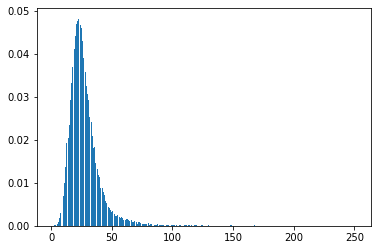

In [127]:
plt.bar(dict_.keys(),dict_.values())

In [159]:
all_df["bond_type_counter"] =  all_df["logical_expression"].apply(lambda x: dict(Counter(np.array([i.split("-") for i in x.split('^')])[:,1])))

In [160]:
all_df["bond_type_counter_idf"]  = all_df["bond_type_counter"].apply(lambda x: str(x.get('1',0))+"-"+str(x.get('2',0))+"-"+str(x.get('3',0))+"-"+str(x.get('4',0)) )

In [151]:
from collections import Counter

In [162]:
len(set(all_df["bond_type_counter_idf"]))

4613

In [168]:
dict_ = dict(all_df['bond_type_counter_idf'].value_counts(normalize=False))

{'10-6-2-0': 221,
 '11-6-2-0': 219,
 '9-6-2-0': 217,
 '9-12-2-0': 209,
 '11-12-2-0': 191,
 '7-12-2-0': 190,
 '8-12-2-0': 189,
 '12-12-2-0': 186..}

(array([4.148e+03, 2.400e+02, 1.050e+02, 5.800e+01, 2.000e+01, 1.500e+01,
        1.500e+01, 4.000e+00, 4.000e+00, 4.000e+00]),
 array([2.43149269e-05, 5.59243319e-04, 1.09417171e-03, 1.62910010e-03,
        2.16402850e-03, 2.69895689e-03, 3.23388528e-03, 3.76881367e-03,
        4.30374207e-03, 4.83867046e-03, 5.37359885e-03]),
 <BarContainer object of 10 artists>)

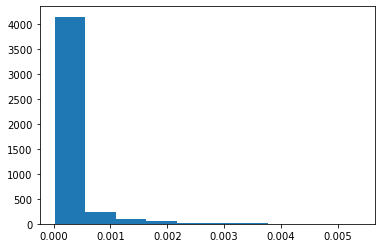

In [166]:
plt.hist(dict_.values())